In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/Steel_industry_data.csv')
data['date'] = pd.to_datetime(data['date'], format="%d/%m/%Y %H:%M")
data.sort_values('date', inplace=True)

# Assuming 'Usage_kWh' is the target variable
target = data['Usage_kWh']
# all other columns are features
features = data.drop(['Usage_kWh'], axis=1)

# Convert 'date' column to Unix timestamp (number of seconds since 1970-01-01)
features = pd.get_dummies(features, columns=['WeekStatus'])
features = features.select_dtypes(include=[np.number])

# Normalize the features
scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)

# Normalize the target
scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, random_state=42)


In [ ]:
# After preprocessing and splitting the data
n_features = X_train.shape[1]  # Confirm this is the correct number of feature columns
print("n_features", n_features)

# Calculate n_seq and n_steps for X_train
total_samples_train = X_train.shape[0]
n_steps_train = 100  # Arbitrary choice for demonstration

# Adjust n_steps_train if necessary
while total_samples_train % n_steps_train != 0:
    n_steps_train -= 1

n_seq_train = int(total_samples_train / n_steps_train)
print("n_steps for train:", n_steps_train)

# Confirm that the product of n_seq_train and n_steps_train matches total_samples_train
assert n_seq_train * n_steps_train == total_samples_train, "The product of n_seq_train and n_steps_train must match the total number of samples in X_train"

# Now you can reshape X_train
X_train_reshaped = X_train.reshape((n_seq_train, 1, n_steps_train, n_features))

# Calculate n_seq and n_steps for X_test
total_samples_test = X_test.shape[0]
n_steps_test = n_steps_train  # We'll use the same n_steps for X_test

# Adjust n_steps_test if necessary
while total_samples_test % n_steps_test != 0:
    n_steps_test -= 1

n_seq_test = int(total_samples_test / n_steps_test)
print("n_steps for test:", n_steps_test)

# Confirm that the product of n_seq_test and n_steps_test matches total_samples_test
assert n_seq_test * n_steps_test == total_samples_test, "The product of n_seq_test and n_steps_test must match the total number of samples in X_test"

# Now you can reshape X_test
X_test_reshaped = X_test.reshape((n_seq_test, 1, n_steps_test, n_features))

n_features 6
n_steps for train: 96
n_steps for test: 96


In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps_train, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
history = model.fit(X_train_reshaped, y_train[:n_seq_train], epochs=100, validation_data=(X_test_reshaped, y_test[:n_seq_test]))


Epoch 1/100
10/10 [==============================] - 3s 93ms/step - loss: 0.0673 - val_loss: 0.0495
Epoch 2/100
10/10 [==============================] - 0s 47ms/step - loss: 0.0468 - val_loss: 0.0398
Epoch 3/100
10/10 [==============================] - 0s 47ms/step - loss: 0.0464 - val_loss: 0.0396
Epoch 4/100
10/10 [==============================] - 0s 42ms/step - loss: 0.0445 - val_loss: 0.0385
Epoch 5/100
10/10 [==============================] - 0s 43ms/step - loss: 0.0421 - val_loss: 0.0385
Epoch 6/100
10/10 [==============================] - 0s 40ms/step - loss: 0.0414 - val_loss: 0.0390
Epoch 7/100
10/10 [==============================] - 0s 35ms/step - loss: 0.0422 - val_loss: 0.0401
Epoch 8/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0388 - val_loss: 0.0399
Epoch 9/100
10/10 [==============================] - 0s 18ms/step - loss: 0.0389 - val_loss: 0.0402
Epoch 10/100
10/10 [==============================] - 0s 17ms/step - loss: 0.0357 - val_loss: 0.0411

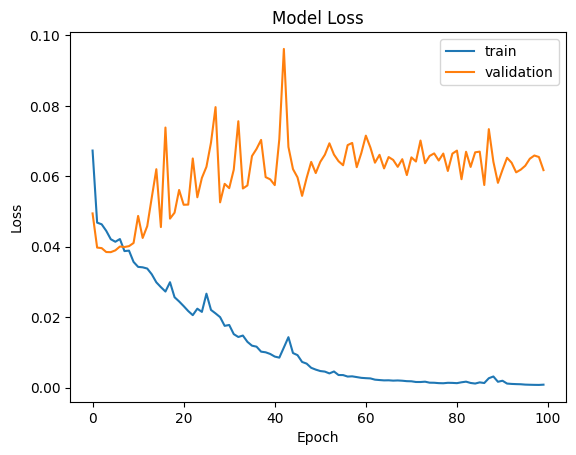

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test_reshaped)
predictions_inverse = scaler_target.inverse_transform(predictions)
y_test_inverse = scaler_target.inverse_transform(y_test[:n_seq_test])

3/3 [==============================] - 0s 7ms/step


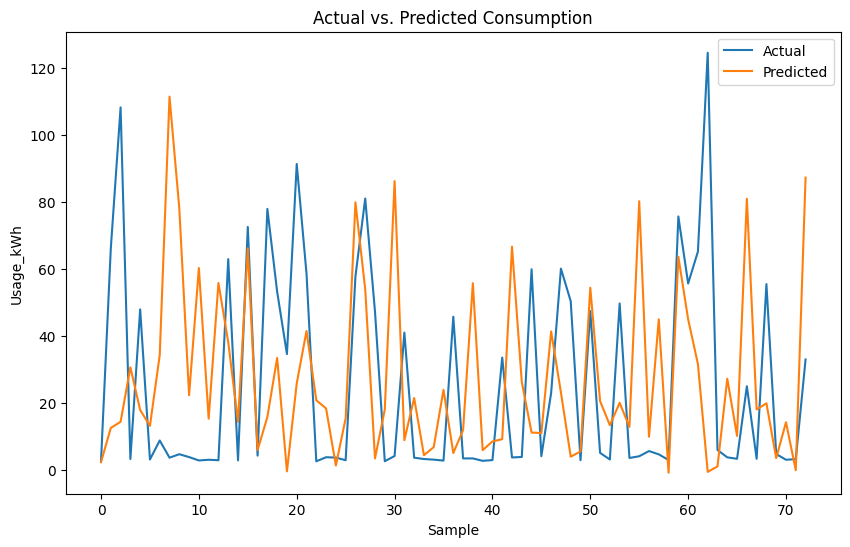

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='Actual')
plt.plot(predictions_inverse, label='Predicted')
plt.title('Actual vs. Predicted Consumption')
plt.xlabel('Sample')
plt.ylabel('Usage_kWh')
plt.legend()
plt.show()

In [ ]:
print(predictions.shape)

(73, 1)


In [ ]:
if predictions.ndim == 1:
    predictions = predictions.reshape(-1, 1)

In [ ]:
predictions_inverse_scaled = scaler_target.inverse_transform(predictions.squeeze())
y_test_inverse_scaled = scaler_target.inverse_transform(y_test[:n_seq_test].squeeze())

mse = mean_squared_error(y_test_inverse_scaled, predictions_inverse_scaled)
mae = mean_absolute_error(y_test_inverse_scaled, predictions_inverse_scaled)
r2 = r2_score(y_test_inverse_scaled, predictions_inverse_scaled)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

ValueError: Expected 2D array, got 1D array instead:
array=[ 1.46048162e-02  7.97507018e-02  9.13936049e-02  1.95037037e-01
  1.13830015e-01  8.36403221e-02  2.18239397e-01  7.09439337e-01
  4.96926159e-01  1.41969636e-01  3.83670419e-01  9.73097607e-02
  3.55222136e-01  2.42791891e-01  9.11942124e-02  4.21161383e-01
  3.76341715e-02  1.00497231e-01  2.12841034e-01 -2.77133845e-03
  1.64307728e-01  2.63944179e-01  1.32333949e-01  1.16716266e-01
  8.22459906e-03  9.80152711e-02  5.08576334e-01  3.43167156e-01
  2.17191149e-02  1.14760906e-01  5.48864186e-01  5.64685985e-02
  1.36477470e-01  2.78718267e-02  4.32948321e-02  1.52106941e-01
  3.19972783e-02  7.56268278e-02  3.54874551e-01  3.74289900e-02
  5.39228097e-02  5.83554506e-02  4.24180388e-01  1.67038977e-01
  7.09635764e-02  7.00054243e-02  2.63126671e-01  1.47063956e-01
  2.50518192e-02  3.50751877e-02  3.46166283e-01  1.30672097e-01
  8.49010199e-02  1.27454221e-01  8.15786943e-02  5.10661542e-01
  6.28617704e-02  2.86254734e-01 -5.41984243e-03  4.05014396e-01
  2.86187410e-01  2.01140612e-01 -3.78683303e-03  6.54355809e-03
  1.73311517e-01  6.45124018e-02  5.15297294e-01  1.14858642e-01
  1.26517773e-01  2.23806519e-02  9.05839354e-02 -6.75410032e-04
  5.55525362e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
import hashlib
import datetime

class Block:
    def __init__(self, index, timestamp, data, previous_hash):
        self.index = index
        self.timestamp = timestamp
        self.data = data
        self.previous_hash = previous_hash
        self.hash = self.calculate_hash()

    def calculate_hash(self):
        # You can use any hashing algorithm here
        return hashlib.sha256((str(self.index) + str(self.timestamp) + str(self.data) + self.previous_hash).encode()).hexdigest()

class Blockchain:
    def __init__(self):
        self.chain = [self.create_genesis_block()]

    def create_genesis_block(self):
        return Block(0, datetime.datetime.now(), "Genesis Block", "0")

    def get_latest_block(self):
        return self.chain[-1]

    def add_block(self, new_block):
        new_block.previous_hash = self.get_latest_block().hash
        new_block.hash = new_block.calculate_hash()
        self.chain.append(new_block)

    def print_chain(self):
        for block in self.chain:
            print(vars(block))

# Sample usage
blockchain = Blockchain()
blockchain.add_block(Block(1, datetime.datetime.now(), {"transaction": "Buy", "amount": 100}, blockchain.get_latest_block().hash))
blockchain.add_block(Block(2, datetime.datetime.now(), {"transaction": "Sell", "amount": 50}, blockchain.get_latest_block().hash))
blockchain.add_block(Block(3, datetime.datetime.now(), {"transaction": "Buy", "amount": 200}, blockchain.get_latest_block().hash))

# Print the blockchain
blockchain.print_chain()


{'index': 0, 'timestamp': datetime.datetime(2024, 4, 18, 8, 5, 47, 242902), 'data': 'Genesis Block', 'previous_hash': '0', 'hash': '3f374861db4cb1ceb3eaad1bdda5eece74656c3d70a4faf8877717b8405970bd'}
{'index': 1, 'timestamp': datetime.datetime(2024, 4, 18, 8, 5, 47, 243045), 'data': {'transaction': 'Buy', 'amount': 100}, 'previous_hash': '3f374861db4cb1ceb3eaad1bdda5eece74656c3d70a4faf8877717b8405970bd', 'hash': '0079b1e1e05dfcb82e495035082e34ba0ec798bb9b7e30fa35fb8316f4d8c2e8'}
{'index': 2, 'timestamp': datetime.datetime(2024, 4, 18, 8, 5, 47, 243186), 'data': {'transaction': 'Sell', 'amount': 50}, 'previous_hash': '0079b1e1e05dfcb82e495035082e34ba0ec798bb9b7e30fa35fb8316f4d8c2e8', 'hash': '8c2199aaedfae44fd3f6461a6f3b01d0b183efa5461066495345be5898cccc91'}
{'index': 3, 'timestamp': datetime.datetime(2024, 4, 18, 8, 5, 47, 243305), 'data': {'transaction': 'Buy', 'amount': 200}, 'previous_hash': '8c2199aaedfae44fd3f6461a6f3b01d0b183efa5461066495345be5898cccc91', 'hash': 'dad47163fb119cbe